# REQUIREMENTS

In [1]:
import wrds, datetime
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

conn = wrds.Connection()

# veervohra
# rzoj3miTfgD$

Loading library list...
Done


# DATA COLLECTION

### S&P DATA

In [2]:
snp_d = conn.raw_sql("""
SELECT
    caldt AS date,
    sprtrn AS daily_ret -- Equal-Weighted Return (includes distributions) (ewretd)
FROM
    crspq.dsp500
WHERE
    caldt >= '1990-01-01'
ORDER BY
    caldt;
""")

snp_d['date'] = pd.to_datetime(snp_d['date'])

# Convert dates to quarterly periods
snp_d["date"] = snp_d["date"].dt.to_period("Q").dt.end_time.dt.date

# Calculate quarterly returns
snp_q = snp_d.groupby("date")["daily_ret"].apply(
    lambda x: np.prod(1 + x) - 1  # Compound daily returns
).reset_index()

snp_q.columns = ["date", "snp_ret_q"]

snp_q

,date,snp_ret_q
0,1990-03-31,-0.038087
1,1990-06-30,0.053186
2,1990-09-30,-0.145162
3,1990-12-31,0.078973
4,1991-03-31,0.136273
...,...,...
134,2023-09-30,-0.036477
135,2023-12-31,0.112354
136,2024-03-31,0.101582
137,2024-06-30,0.039227


### FACTORS & RFR

##### (1-month Treasury bill rate)
##### Beginning of Month

In [3]:
factors_d = conn.raw_sql('''
    SELECT
        date,
        mktrf AS market_factor,  -- Market factor (excess return on the market)
        smb AS size_factor,  -- Size factor (Small Minus Big)
        hml AS value_factor,  -- Value factor (High Minus Low)
        umd AS momentum_factor,  -- Momentum factor
        rf AS risk_free_rate -- One Month Treasury Bill Rate (daily)
    FROM
        ff.factors_daily
    WHERE
        date >= '1990-01-01'
''')

factors_d

factors_d['date'] = pd.to_datetime(factors_d['date'])

factors_d["date"] = factors_d["date"].dt.to_period("Q").dt.end_time.dt.date

factors_q = factors_d.groupby("date")[["market_factor", "size_factor", "value_factor", "momentum_factor", "risk_free_rate"]].apply(
    lambda x: np.prod(1 + x) - 1
).reset_index()

factors_q.columns = factors_d.columns

factors_q


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


,date,market_factor,size_factor,value_factor,momentum_factor,risk_free_rate
0,1990-03-31,-0.050910,0.009209,-0.012999,-0.012649,0.017957
1,1990-06-30,0.036516,-0.015511,-0.079474,0.082742,0.020117
2,1990-09-30,-0.171596,-0.105937,0.020555,0.175425,0.019230
3,1990-12-31,0.068621,-0.046955,-0.046106,0.010927,0.018741
4,1991-03-31,0.151269,0.113835,-0.034834,-0.054076,0.014310
...,...,...,...,...,...,...
134,2023-09-30,-0.044847,-0.038656,0.043262,0.012649,0.013286
135,2023-12-31,0.104011,0.018790,0.065183,-0.010492,0.013316
136,2024-03-31,0.087816,-0.073035,-0.019281,0.099526,0.013104
137,2024-06-30,0.022196,-0.046186,-0.052921,0.028012,0.013286


### COMPANY DATA

In [4]:
# retrieves ID (permno) and earliest recorded name for each company in CRSP database
# 37,776 companies available
conn.raw_sql( '''
SELECT permno, MIN(comnam) AS company_name
FROM crsp.stocknames
GROUP BY permno
''')

,permno,company_name
0,83264,GREIF BROTHERS CORP
1,63618,HINDERLITER ENERGY EQUIP CORP
2,10896,CAMILLE ST MORITZ INC
3,69906,SEIBELS BRUCE GROUP INC
4,79030,GREAT CENTRAL MINES LTD
...,...,...
37771,14886,ARK E T F TRUST
37772,79163,A M F M INC
37773,86036,BRENTWOOD INSTRUMENTS INC
37774,92970,CHINA EDUCATION ALLIANCE INC


In [5]:
# Using NVIDIA as example to figure out the algorithm.

conn.raw_sql('''
SELECT *
FROM crsp.ccmxpf_linktable
WHERE lpermno = 86580;
''')

,gvkey,linkprim,liid,linktype,lpermno,lpermco,usedflag,linkdt,linkenddt
0,117768,P,01,LU,86580.0,16382.0,1.0,1999-01-22,None


In [ ]:
#Getting NVIDIA time series data.

nvidia = conn.raw_sql('''
WITH comp_data AS (
    SELECT
        f.gvkey,
        f.datadate AS date,
        f.atq AS total_assets,  -- Total Assets
        f.chq AS cash_holdings,  -- Cash and Short-Term Investments
        -- f.dlttq + f.dlcq AS total_debt,  -- Total Debt (long-term + short-term debt)
        -- f.ibq AS earnings,  -- Earnings before extraordinary items
        -- f.xrdq AS rd_expense,  -- R&D expense
        -- f.dvpq AS dividends_paid,  -- Dividends paid
        -- f.xintq AS interest_expense,  -- Interest expense
        -- f.prccq * f.cshoq AS market_cap,  -- Market cap (price * shares outstanding)
        f.rdq AS reporting_date -- Date of which information was reported
    FROM
        comp.fundq f
    WHERE
        gvkey = '117768'
        AND f.datadate >= '1990-01-01'  -- Ensure data is after the link start date
),
crsp_data AS (
    SELECT
        permno,
        date,
        ret AS stock_return,  -- Stock returns from CRSP
        prc AS stock_price,
        prc * shrout AS market_cap  -- Market cap
    FROM
        crsp.msf
    WHERE
        permno = 86580  -- Use the correct permno for gvkey 003243
)
SELECT
    c.gvkey,
    cr.permno,
    c.date, -- Date of each quarter (this is when the information was real)
    c.reporting_date, -- Reporting date (this is when information became known to us)
    cr.stock_price,
    c.cash_holdings,
    c.total_assets
    -- c.market_cap,
    -- c.earnings,
    -- c.total_debt,
    -- c.rd_expense,
    -- c.dividends_paid,
    -- c.interest_expense
FROM
    comp_data c
JOIN
    crsp_data cr ON c.date = cr.date
ORDER BY
    c.gvkey, c.date;

''')

nvidia

,gvkey,permno,date,reporting_date,stock_price,cash_holdings,total_assets
0,117768,86580,1999-04-30,1999-05-18,18.25000,NaN,126.656
1,117768,86580,2000-01-31,2000-02-15,37.06250,NaN,202.250
2,117768,86580,2000-07-31,2000-08-21,60.00000,NaN,507.183
3,117768,86580,2000-10-31,2000-11-09,62.14063,NaN,983.346
4,117768,86580,2001-01-31,2001-02-14,51.62500,NaN,1016.427
...,...,...,...,...,...,...,...
65,117768,86580,2022-01-31,2022-02-16,244.86000,1990.0,44187.000
66,117768,86580,2022-10-31,2022-11-16,134.97000,2800.0,40488.000
67,117768,86580,2023-01-31,2023-02-22,195.37000,3389.0,41182.000
68,117768,86580,2023-07-31,2023-08-23,467.29001,5783.0,49555.000


# CALCULATIONS (CASH-HEDGING & RETURNS)

In [18]:
nvidia['cash_share_weight'] = (nvidia['cash_holdings']/nvidia['total_assets']) #.shift(2) - why are we lagging here? lagging should be a pre-calculation adjustment
nvidia['quarterly_return'] = nvidia['stock_price'].pct_change(fill_method=None)

In [19]:
nvidia

,gvkey,permno,date,reporting_date,stock_price,cash_holdings,total_assets,cash_share_weight,quarterly_return
0,117768,86580,1999-04-30,1999-05-18,18.25000,NaN,126.656,NaN,NaN
1,117768,86580,2000-01-31,2000-02-15,37.06250,NaN,202.250,NaN,1.030822
2,117768,86580,2000-07-31,2000-08-21,60.00000,NaN,507.183,NaN,0.618887
3,117768,86580,2000-10-31,2000-11-09,62.14063,NaN,983.346,NaN,0.035677
4,117768,86580,2001-01-31,2001-02-14,51.62500,NaN,1016.427,NaN,-0.169223
...,...,...,...,...,...,...,...,...,...
65,117768,86580,2022-01-31,2022-02-16,244.86000,1990.0,44187.000,0.045036,-0.592158
66,117768,86580,2022-10-31,2022-11-16,134.97000,2800.0,40488.000,0.069156,-0.448787
67,117768,86580,2023-01-31,2023-02-22,195.37000,3389.0,41182.000,0.082293,0.447507
68,117768,86580,2023-07-31,2023-08-23,467.29001,5783.0,49555.000,0.116699,1.391821


### $ b_{t}^{i} $ - return on cash between periods

In [20]:
# the paper calculates it in a pretty complicated method, we'll start like this

nvidia['cash_holdings_t_minus_1'] = nvidia['cash_holdings'].shift()
nvidia['b_it'] = ( nvidia['cash_holdings'] - nvidia['cash_holdings_t_minus_1'] ) / nvidia['cash_holdings_t_minus_1']

### $ e_{t}^{i} $ - cash hedged returns

In [21]:
# calculate the cash-hedged return (e_it)

nvidia['cash_hedged_return'] = (1 / (1 - nvidia['cash_share_weight'])) * (nvidia['quarterly_return'] - (nvidia['cash_share_weight']  * nvidia['b_it']))

nvidia

,gvkey,permno,date,reporting_date,stock_price,cash_holdings,total_assets,cash_share_weight,quarterly_return,cash_holdings_t_minus_1,b_it,cash_hedged_return
0,117768,86580,1999-04-30,1999-05-18,18.25000,NaN,126.656,NaN,NaN,NaN,NaN,NaN
1,117768,86580,2000-01-31,2000-02-15,37.06250,NaN,202.250,NaN,1.030822,NaN,NaN,NaN
2,117768,86580,2000-07-31,2000-08-21,60.00000,NaN,507.183,NaN,0.618887,NaN,NaN,NaN
3,117768,86580,2000-10-31,2000-11-09,62.14063,NaN,983.346,NaN,0.035677,NaN,NaN,NaN
4,117768,86580,2001-01-31,2001-02-14,51.62500,NaN,1016.427,NaN,-0.169223,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
65,117768,86580,2022-01-31,2022-02-16,244.86000,1990.0,44187.000,0.045036,-0.592158,978.0,1.034765,-0.668884
66,117768,86580,2022-10-31,2022-11-16,134.97000,2800.0,40488.000,0.069156,-0.448787,1990.0,0.407035,-0.512370
67,117768,86580,2023-01-31,2023-02-22,195.37000,3389.0,41182.000,0.082293,0.447507,2800.0,0.210357,0.468773
68,117768,86580,2023-07-31,2023-08-23,467.29001,5783.0,49555.000,0.116699,1.391821,3389.0,0.706403,1.482376


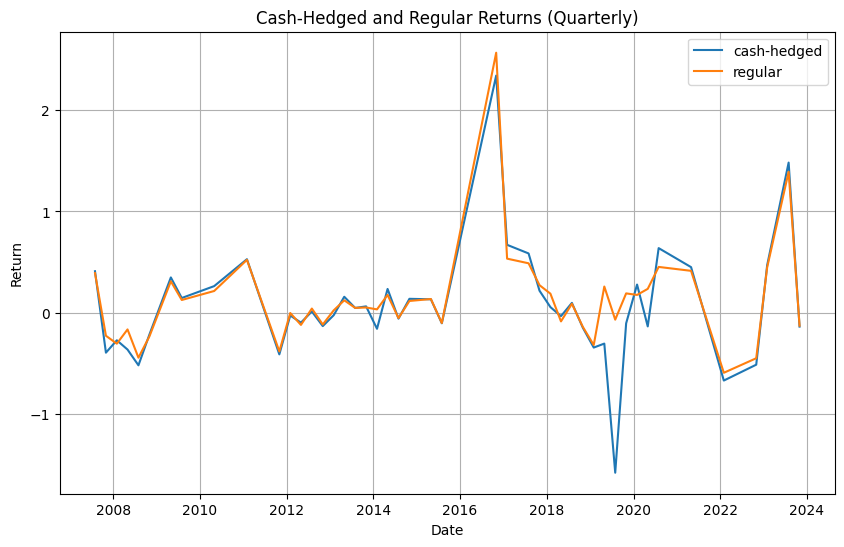

In [27]:
plt.figure(figsize=(10, 6))

temp = nvidia.dropna()

plt.plot(temp['date'], temp['cash_hedged_return'], label=f'cash-hedged')
plt.plot(temp['date'], temp['quarterly_return'], label=f'regular')

plt.title('Cash-Hedged and Regular Returns (Quarterly)')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.show()

# BETA CALCULATION

Seems like in some instances cash_hedged_returns is getting super over inflated. Ideally, that is what we want! But will need to make sure the raise in risk is also reflected.

Next steps:
* Calculate Beta for non-cash assets in NVIDIA
* Use above data to test returns in cash-hedged for NVIDIA over time (long-only) 
* (etc)

Calculating Stock Beta and Cash-Hedged Beta (PiT).

In [ ]:
def rolling_beta_grouped(df, window_size):
    
    def calc_rolling_beta(data):
        betas = []
        
        for start in range(len(data) - window_size + 1):
            window_data = data.iloc[start:start + window_size]

            X = sm.add_constant(window_data['snp_ret']) # (add constant for intercept)
            y = window_data['stock_ret']

            model = sm.OLS(y, X).fit()
            beta = model.params['snp_ret']
            betas.append(beta)
        
        beta_series = pd.Series(betas, index=data.index[window_size - 1:])
        return beta_series

    beta_results = df.groupby('permno').apply(calc_rolling_beta, include_groups=False)

    beta_results = beta_results.reset_index(level=0, drop=True) 

    return beta_results

In [12]:
monthly_comps = '''
WITH cnames AS (
    SELECT permno, MIN(comnam) AS company_name
        FROM crsp.stocknames
        GROUP BY permno
),
cnums AS (
    SELECT date, permno, prc, cfacpr
        FROM crsp.msf
        WHERE date BETWEEN '2008-12-25' AND '2023-12-29'
        AND permno IN (86580)
)

SELECT cnums.permno, cnames.company_name, cnums.date, cnums.prc, cnums.cfacpr
    FROM cnums
    JOIN cnames ON cnums.permno = cnames.permno
    ORDER BY cnums.date;

'''


monthly = conn.raw_sql(monthly_comps)

monthly['prc'] = (abs(monthly['prc']) / monthly['cfacpr'])

monthly['date'] = pd.to_datetime(monthly['date'])

monthly = monthly.sort_values(by=['permno', 'date'])
monthly['stock_ret'] = monthly.groupby('permno')['prc'].pct_change(fill_method=None).fillna(0)

monthly.drop(columns=['cfacpr', 'prc'], inplace=True)

monthly_snp = '''
SELECT date, sprtrn AS snp_ret
    FROM crsp.msi
    WHERE date BETWEEN '2008-12-25' AND '2023-12-29'

'''

sp = conn.raw_sql(monthly_snp)

sp['date'] = pd.to_datetime(sp['date'])

monthly_df = pd.merge(monthly, sp, on='date', how='inner')

monthly_df

,permno,company_name,date,stock_ret,snp_ret
0,86580,NVIDIA CORP,2008-12-31,0.000000,0.007822
1,86580,NVIDIA CORP,2009-01-30,-0.014870,-0.085657
2,86580,NVIDIA CORP,2009-02-27,0.041509,-0.109931
3,86580,NVIDIA CORP,2009-03-31,0.190821,0.085405
4,86580,NVIDIA CORP,2009-04-30,0.164300,0.093925
...,...,...,...,...,...
176,86580,NVIDIA CORP,2023-08-31,0.056196,-0.017716
177,86580,NVIDIA CORP,2023-09-29,-0.118651,-0.048719
178,86580,NVIDIA CORP,2023-10-31,-0.062507,-0.021980
179,86580,NVIDIA CORP,2023-11-30,0.146886,0.089179


In [13]:
monthly_df = monthly_df.sort_values(by=['date'])

In [14]:
monthly_df['PIT_5Y_Beta'] = rolling_beta_grouped(monthly_df, 60).T

In [15]:
nvidia['date'] = pd.to_datetime(nvidia['date'])
combined_data = pd.merge(nvidia, snp_q, on='date', how='inner')
combined_data.sort_values(by='date', inplace=True)

ValueError: You are trying to merge on datetime64[ns] and object columns for key 'date'. If you wish to proceed you should use pd.concat

In [ ]:
window_size = 20
betas = []

for start in range(len(combined_data) - window_size + 1):
    window_data = combined_data.iloc[start:start + window_size]

    X = sm.add_constant(window_data['market_quarterly_return']) # (add constant for intercept)
    y = window_data['cash_hedged_return']

    model = sm.OLS(y, X).fit()
    beta = model.params['market_quarterly_return']
    betas.append(beta)

cash_beta = pd.Series(betas, index=combined_data.index[window_size - 1:])

combined_data['cash_beta'] = cash_beta

####

betas = []

for start in range(len(combined_data) - window_size + 1):
    window_data = combined_data.iloc[start:start + window_size]

    X = sm.add_constant(window_data['market_quarterly_return']) # (add constant for intercept)
    y = window_data['quarterly_return']

    model = sm.OLS(y, X).fit()
    beta = model.params['market_quarterly_return']
    betas.append(beta)

regular_beta = pd.Series(betas, index=combined_data.index[window_size - 1:])

combined_data['regular_beta'] = regular_beta

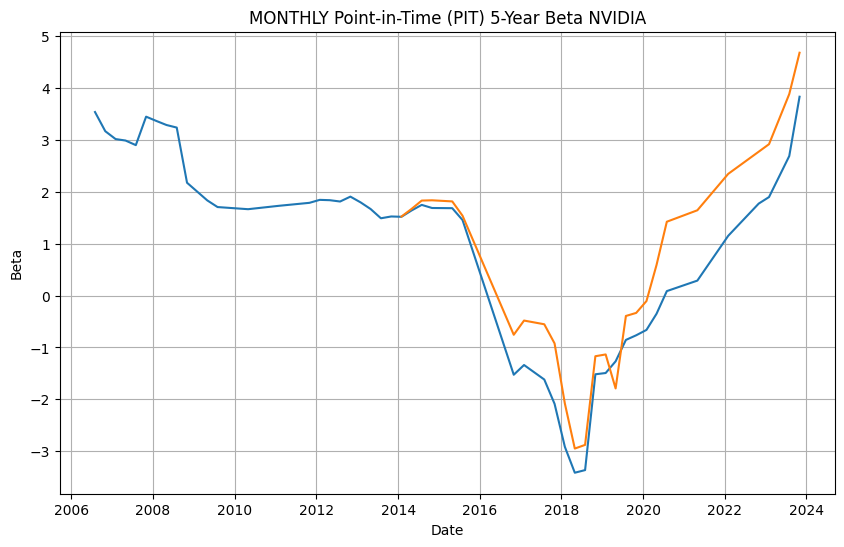

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(combined_data['date'], combined_data['regular_beta'])
plt.plot(combined_data['date'], combined_data['cash_beta'])

plt.title('MONTHLY Point-in-Time (PIT) 5-Year Beta NVIDIA')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.grid(True)
plt.show()

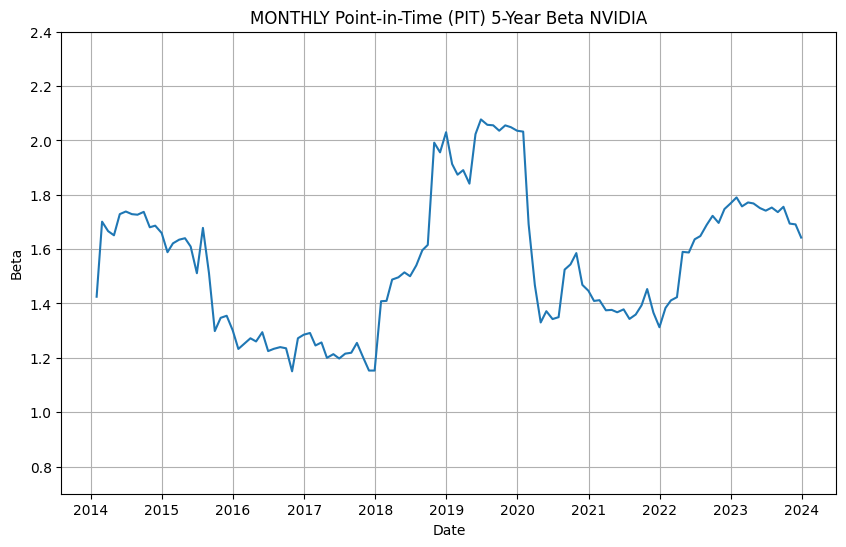

In [ ]:
plt.figure(figsize=(10, 6))

for permno, group_data in monthly_df.groupby('permno'):
    plt.plot(group_data['date'], group_data['PIT_5Y_Beta'])

plt.title('MONTHLY Point-in-Time (PIT) 5-Year Beta NVIDIA')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.ylim(0.7, 2.4)
plt.grid(True)
plt.show()

In [ ]:
def hello():
    print("Hello")